In [1]:
import sys
import os

# --- CONFIGURAZIONE PERCORSI ---
# Il percorso che hai appena trovato
PROJECT_ROOT = "/content/filippo/ML-SRT-SETI"
PROJECT_ROOT_LOCAL = "/home/filippo/TirocinioSETI/ML-SRT-SETI"

# 1. Verifica di sicurezza
if not os.path.exists(PROJECT_ROOT_LOCAL):
    raise FileNotFoundError(f"Attenzione! Non trovo la cartella: {PROJECT_ROOT_LOCAL}")

# 2. Spostiamo la 'Working Directory' lì
# Così quando fai np.load("data/processed/...") lui parte dalla root corretta
os.chdir(PROJECT_ROOT_LOCAL)

# 3. Aggiungiamo la cartella a Python per gli import
# Questo permette di fare 'from src import models' anche se il notebook non è lì fisicamente
if PROJECT_ROOT_LOCAL not in sys.path:
    sys.path.append(PROJECT_ROOT_LOCAL)

print(f"✅ Setup Completato!")
print(f"   Directory di lavoro: {os.getcwd()}")

✅ Setup Completato!
   Directory di lavoro: /home/filippo/TirocinioSETI/ML-SRT-SETI


In [2]:
%matplotlib inline

Caricamento /home/filippo/TirocinioSETI/ML-SRT-SETI/src/synthetic_dataset.npz...

--- VERIFICA STATISTICA: True Cadences (ETI) ---
Shape: (128, 6, 16, 512, 1)
Min Value (atteso ~0): 0.0000
Max Value (atteso ~1): 1.0000
Mean Value: 0.3819
Nessun NaN rilevato.

--- VERIFICA STATISTICA: False Cadences (RFI) ---
Shape: (128, 6, 16, 512, 1)
Min Value (atteso ~0): 0.0000
Max Value (atteso ~1): 1.0000
Mean Value: 0.3628
Nessun NaN rilevato.

Generazione grafici per TRUE CADENCES (Dovresti vedere segnali solo su ON)...


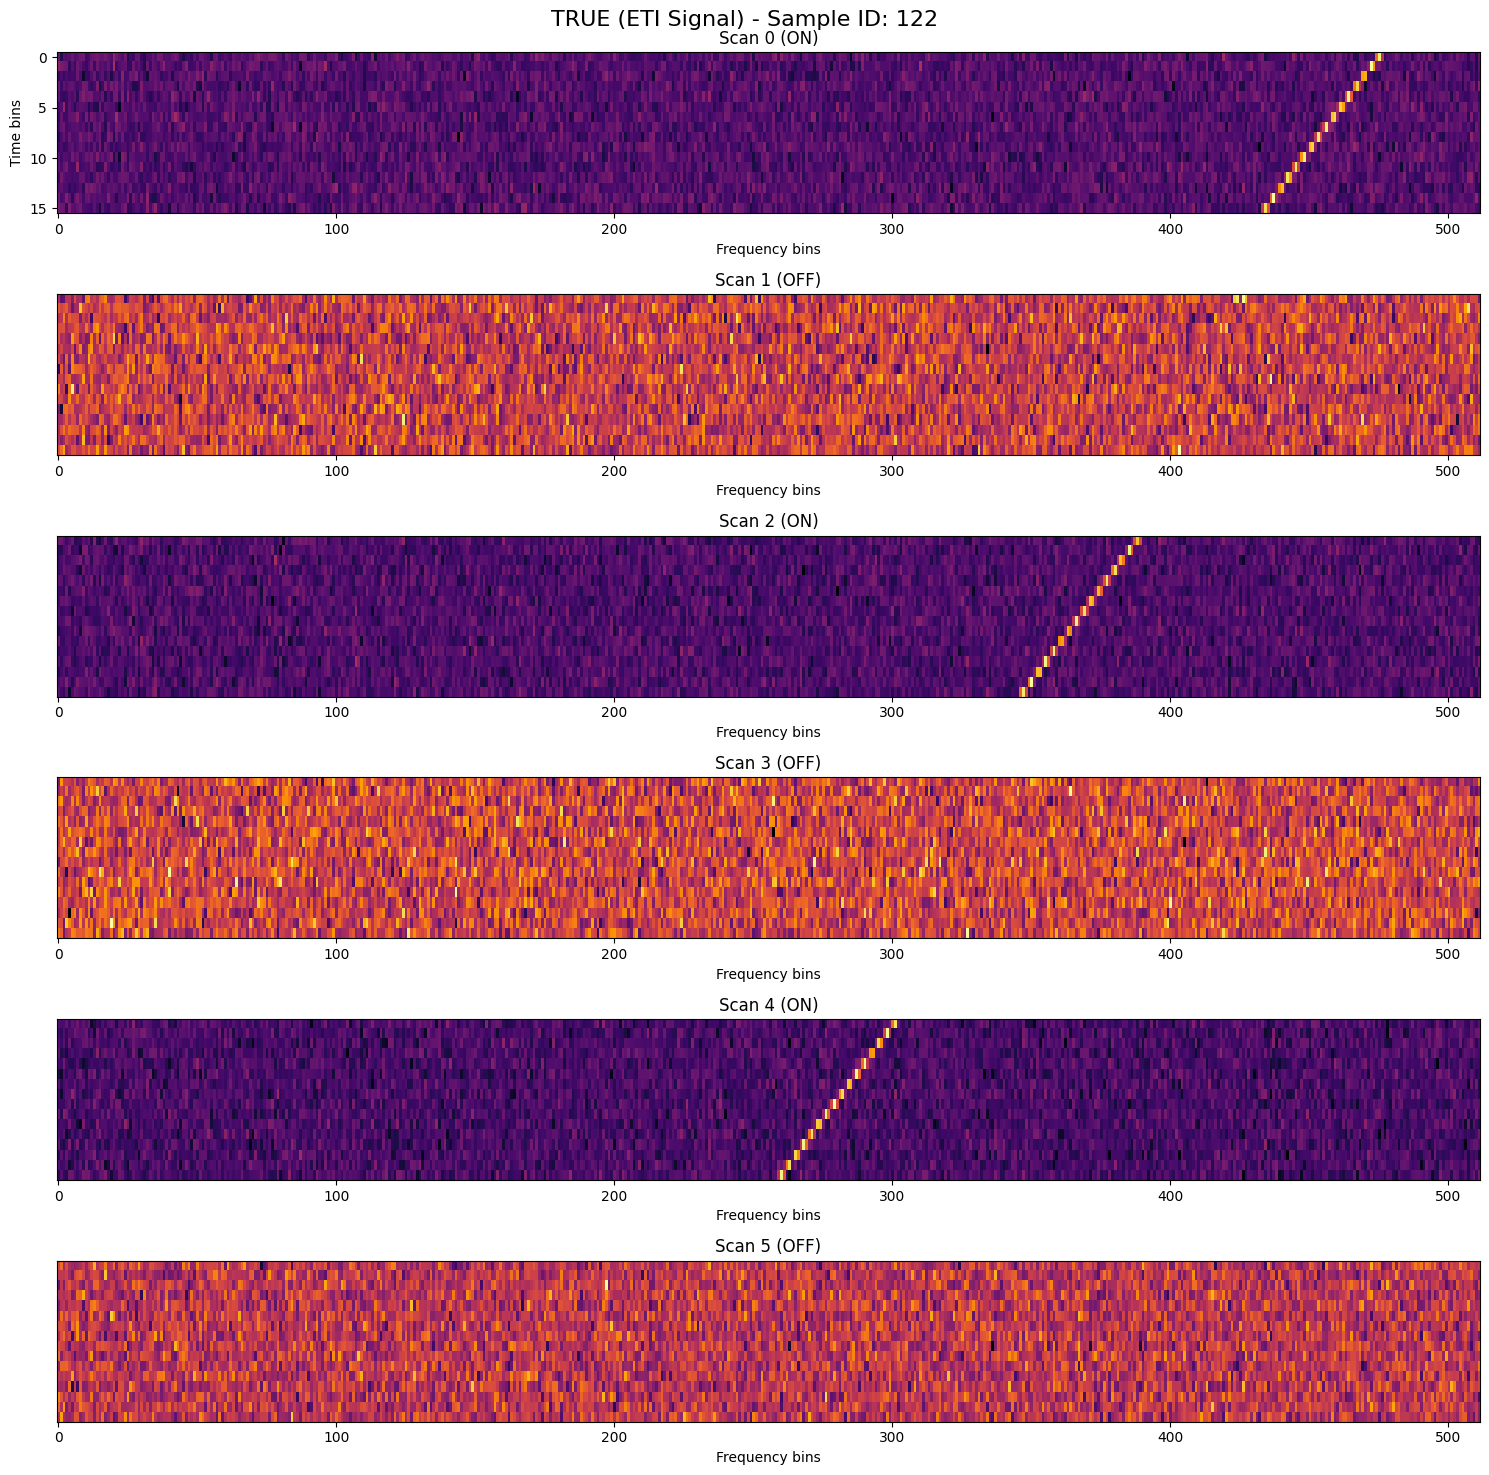

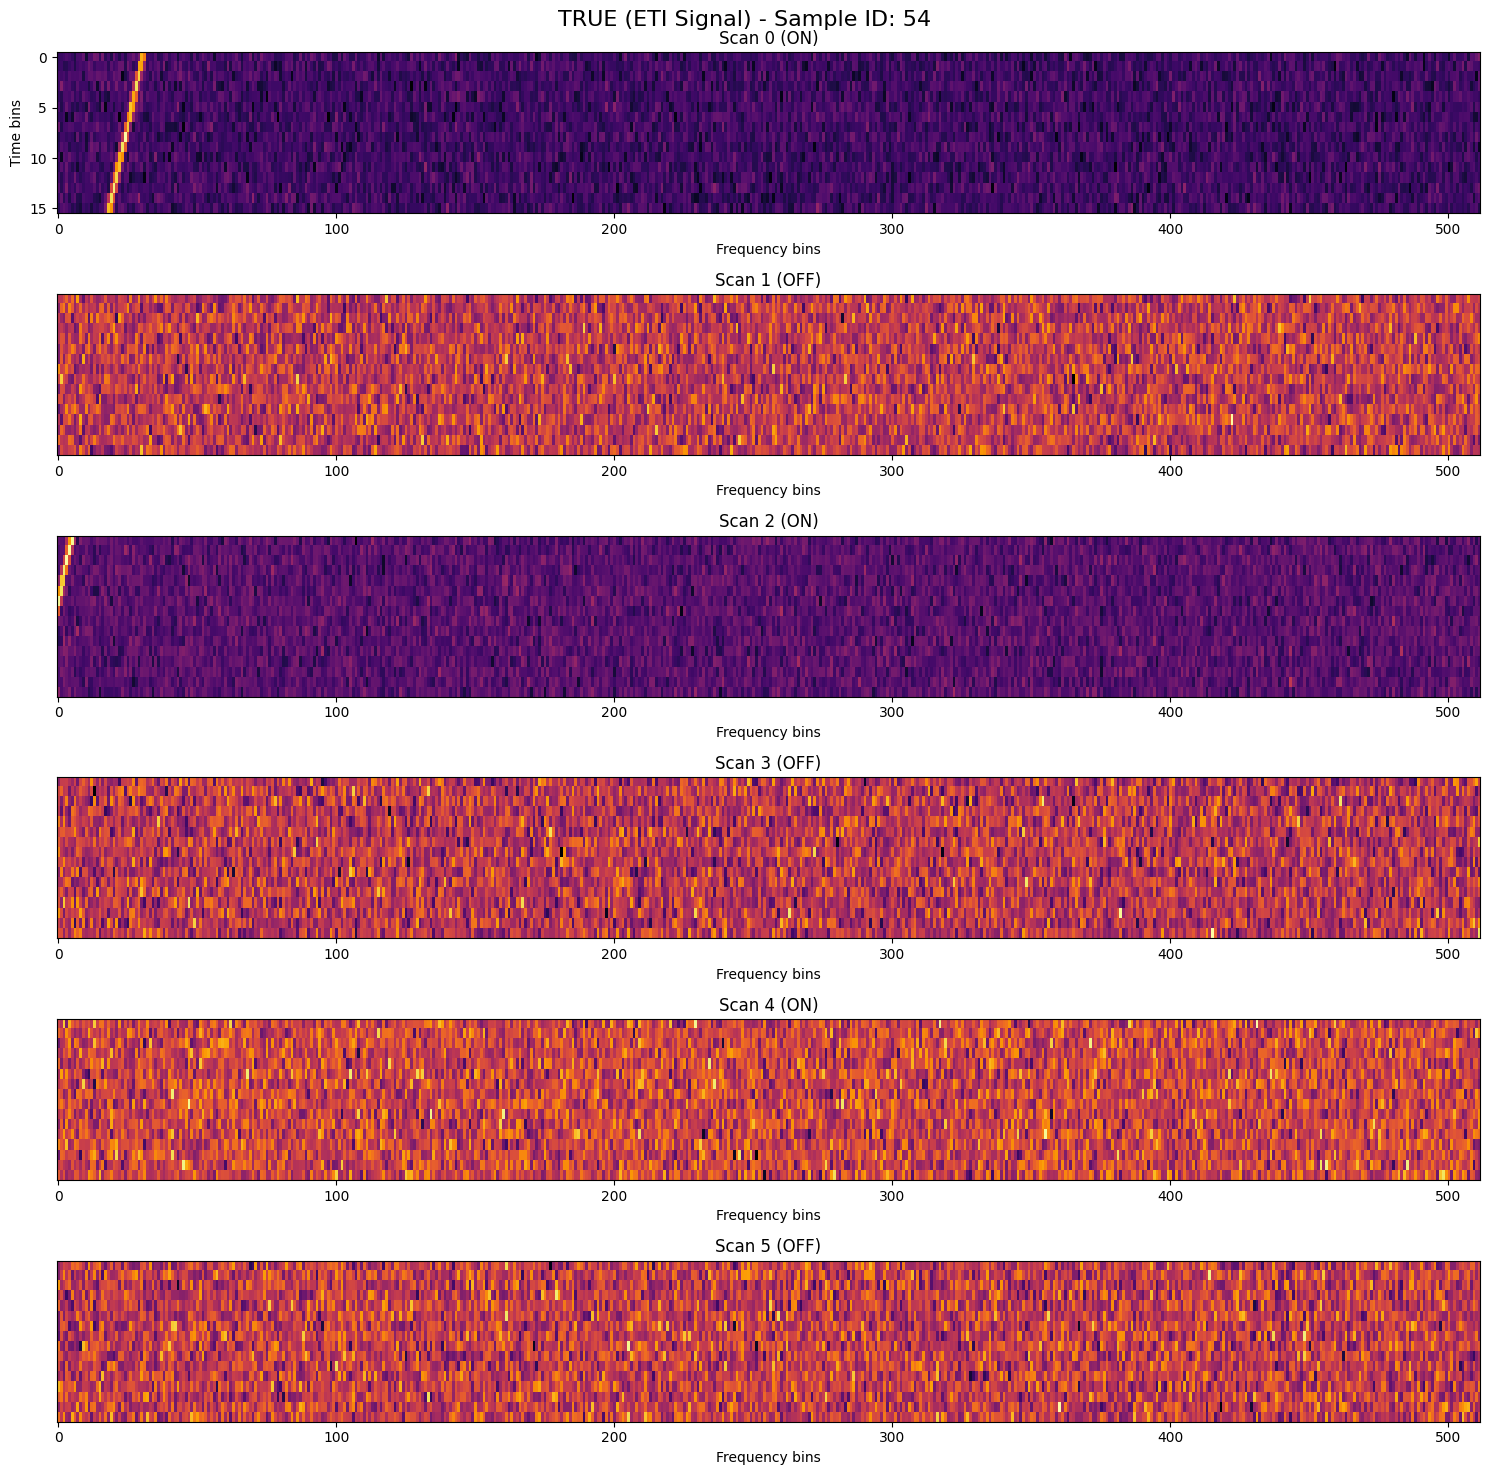

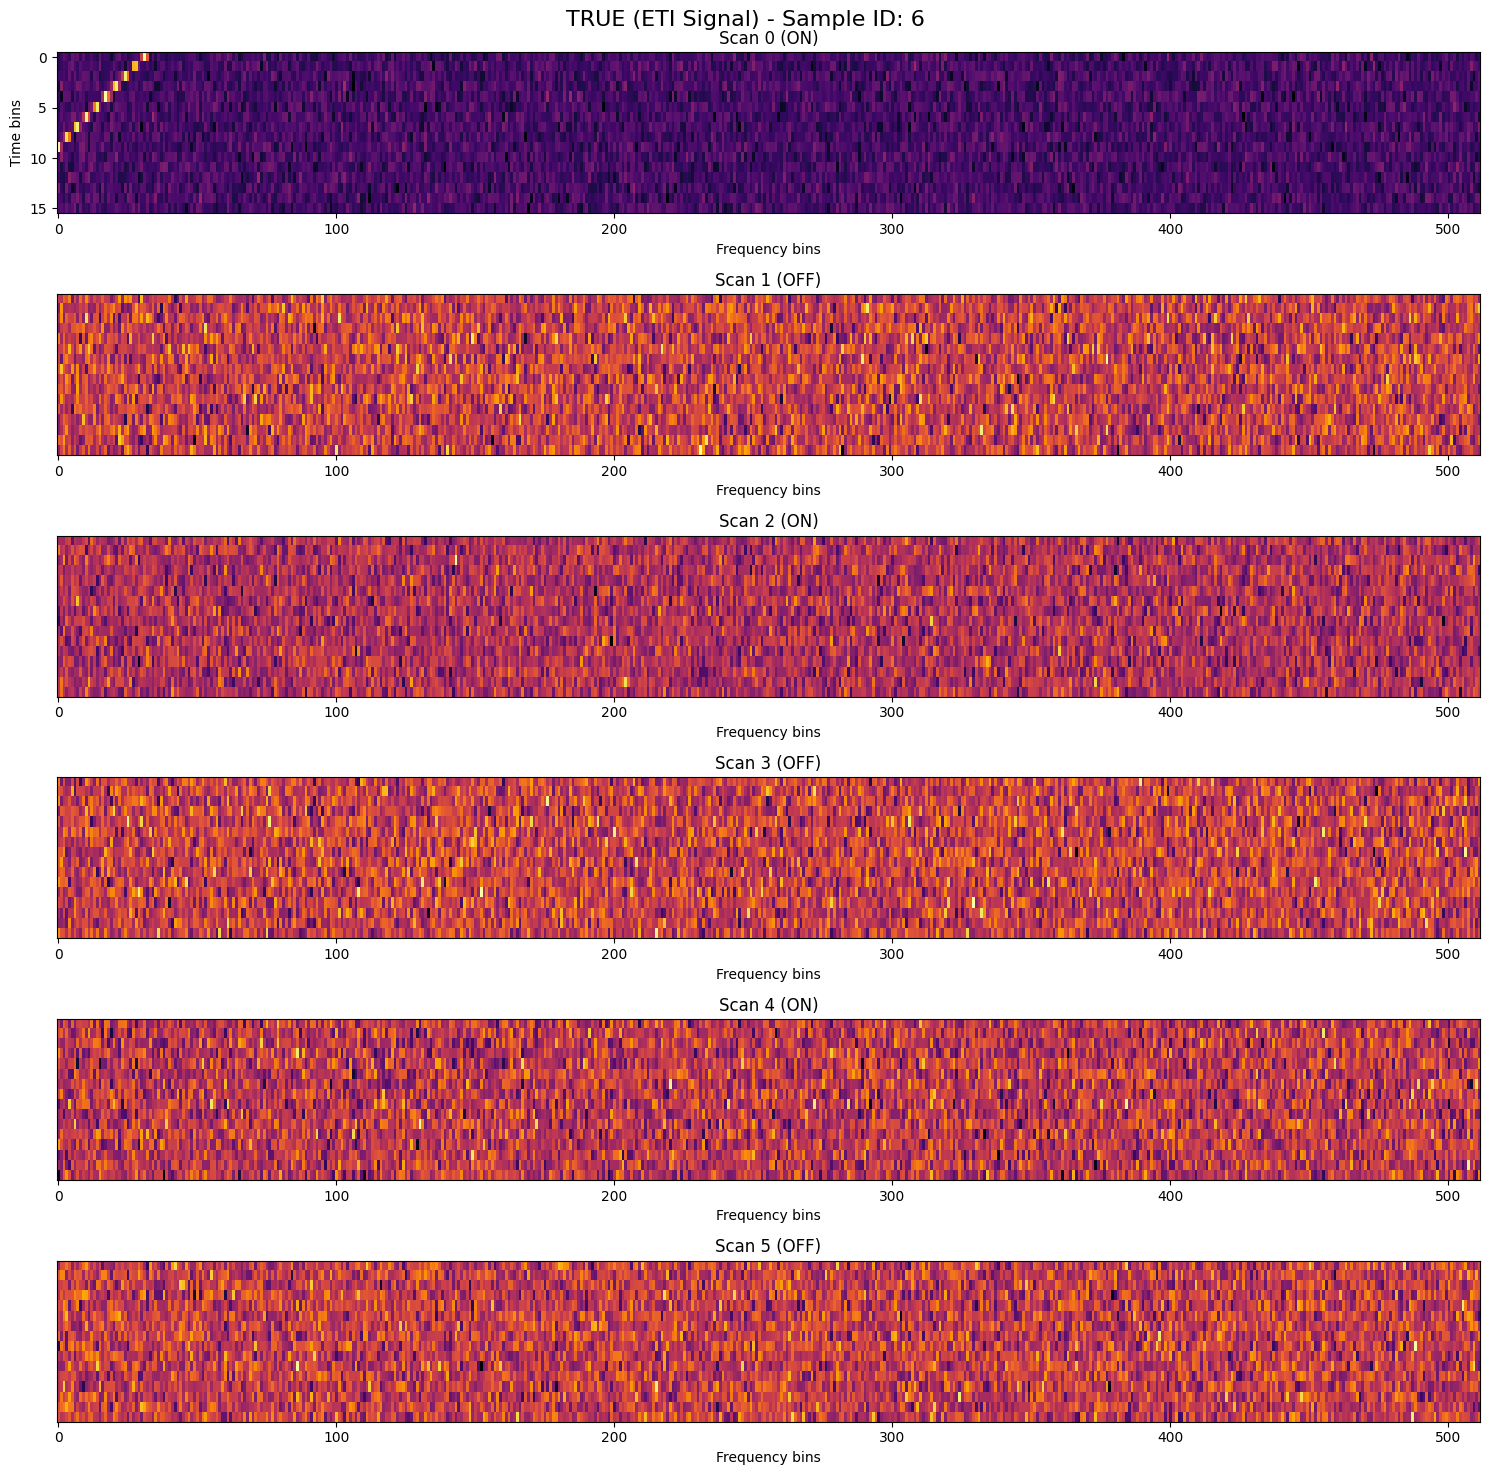


Generazione grafici per FALSE CADENCES (Dovresti vedere segnali continui/verticali)...


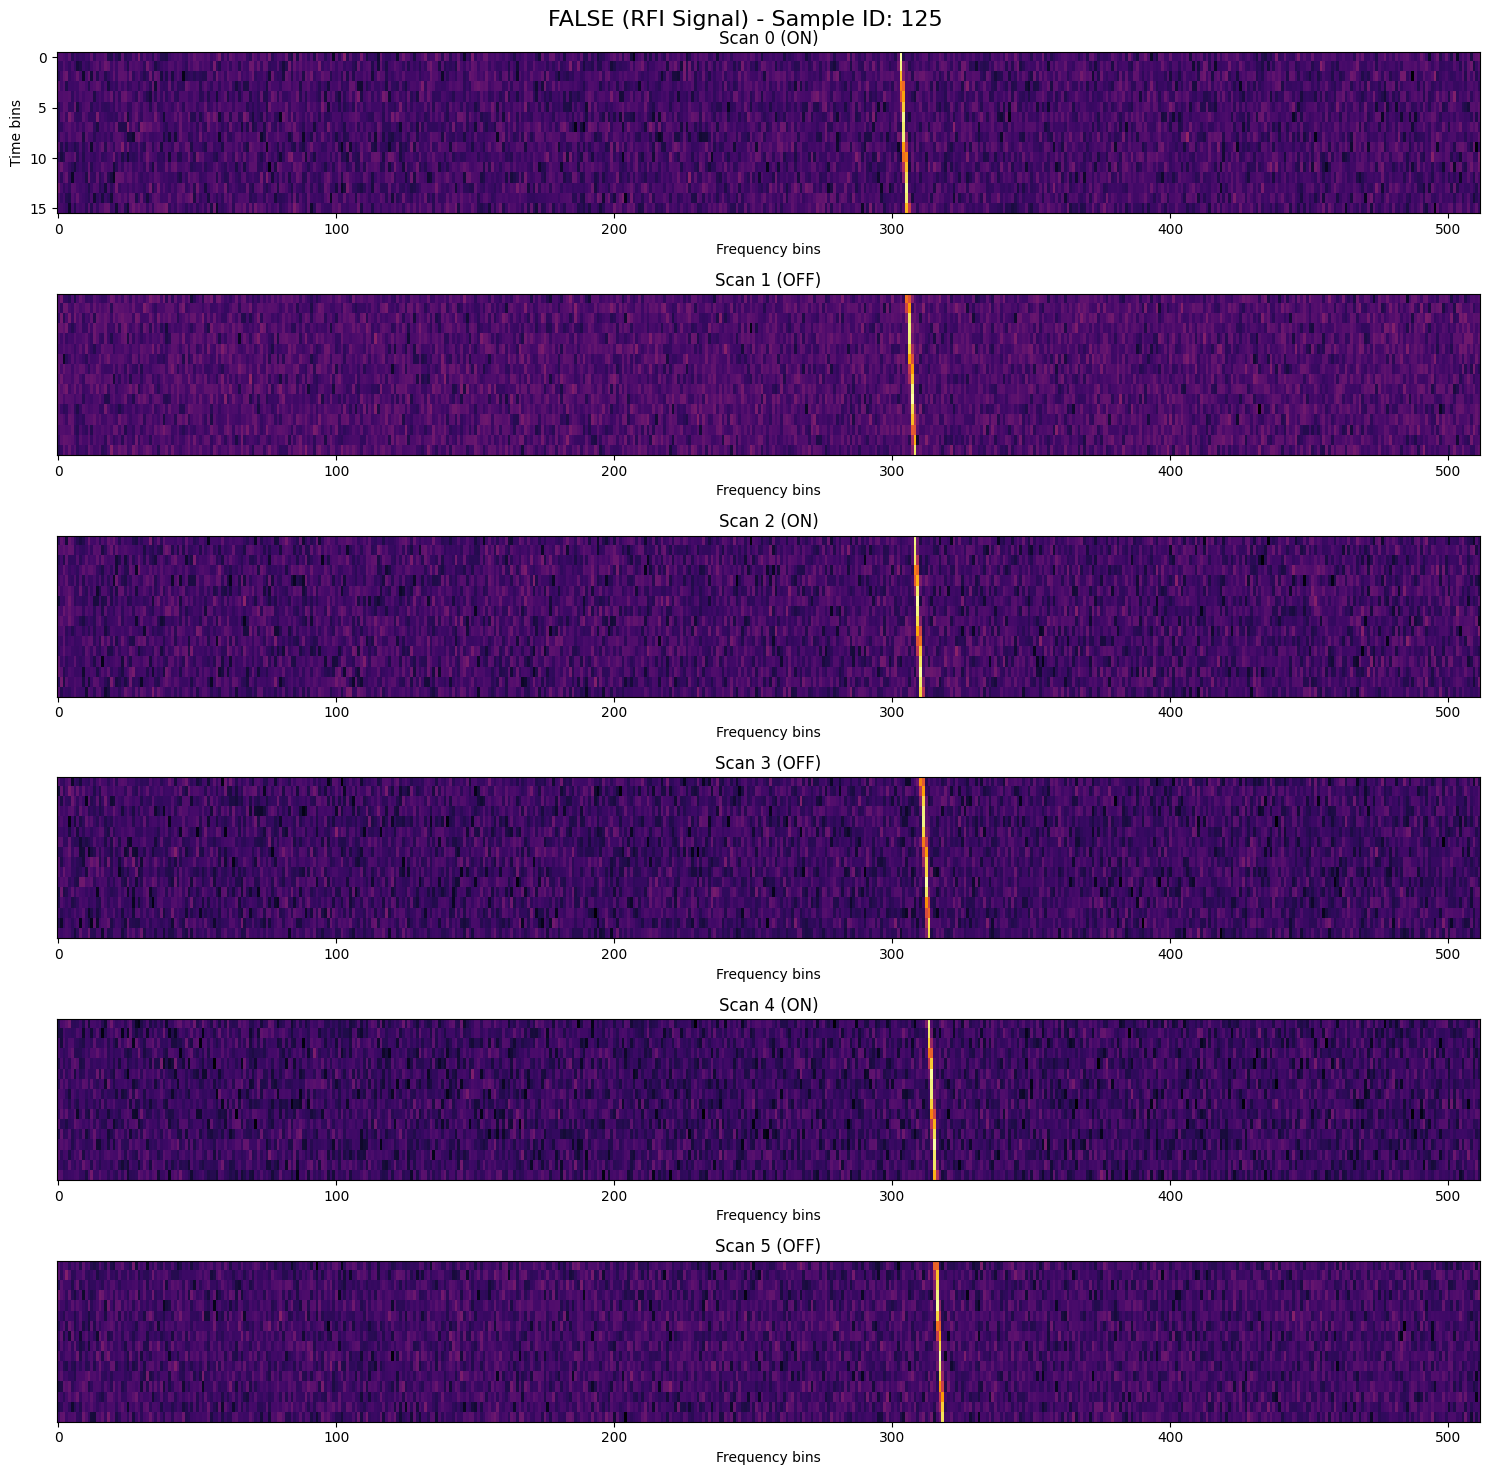

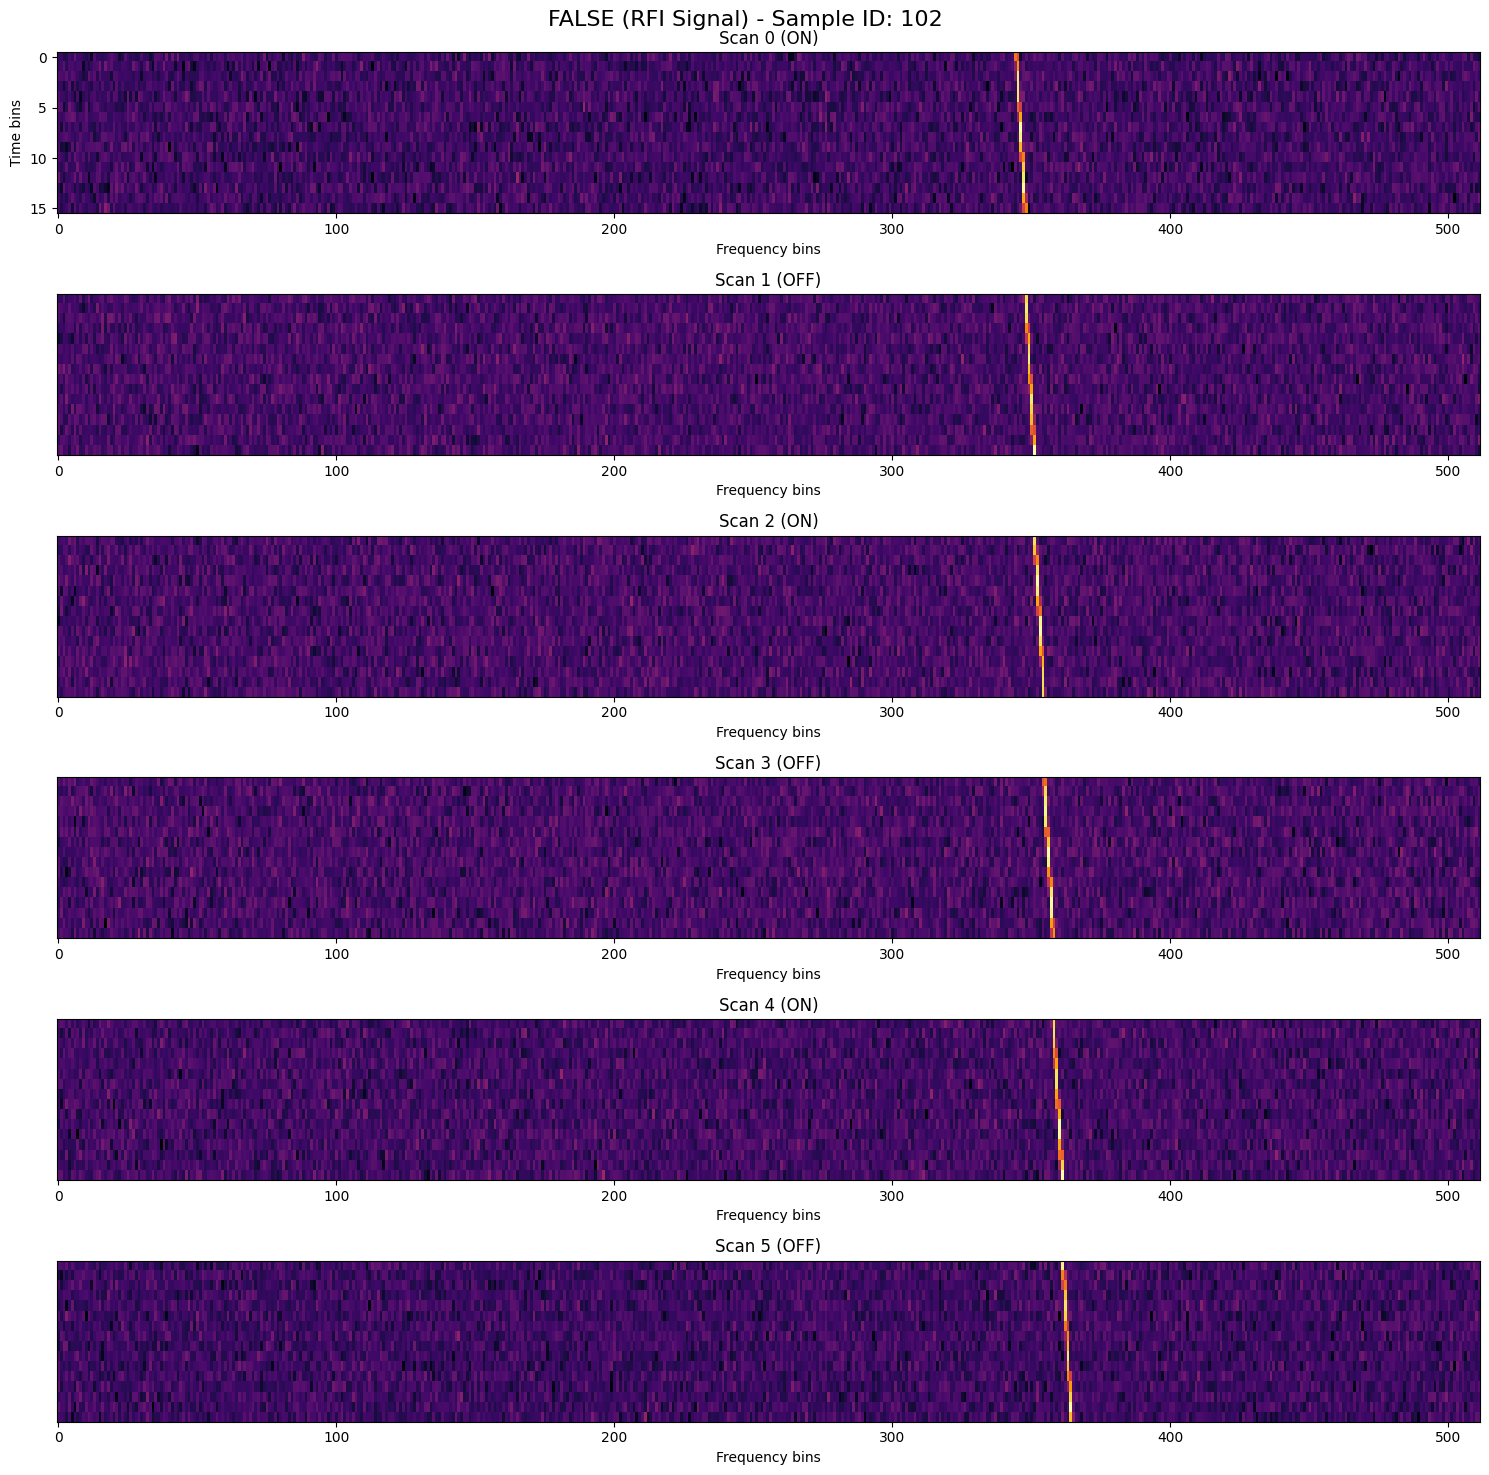

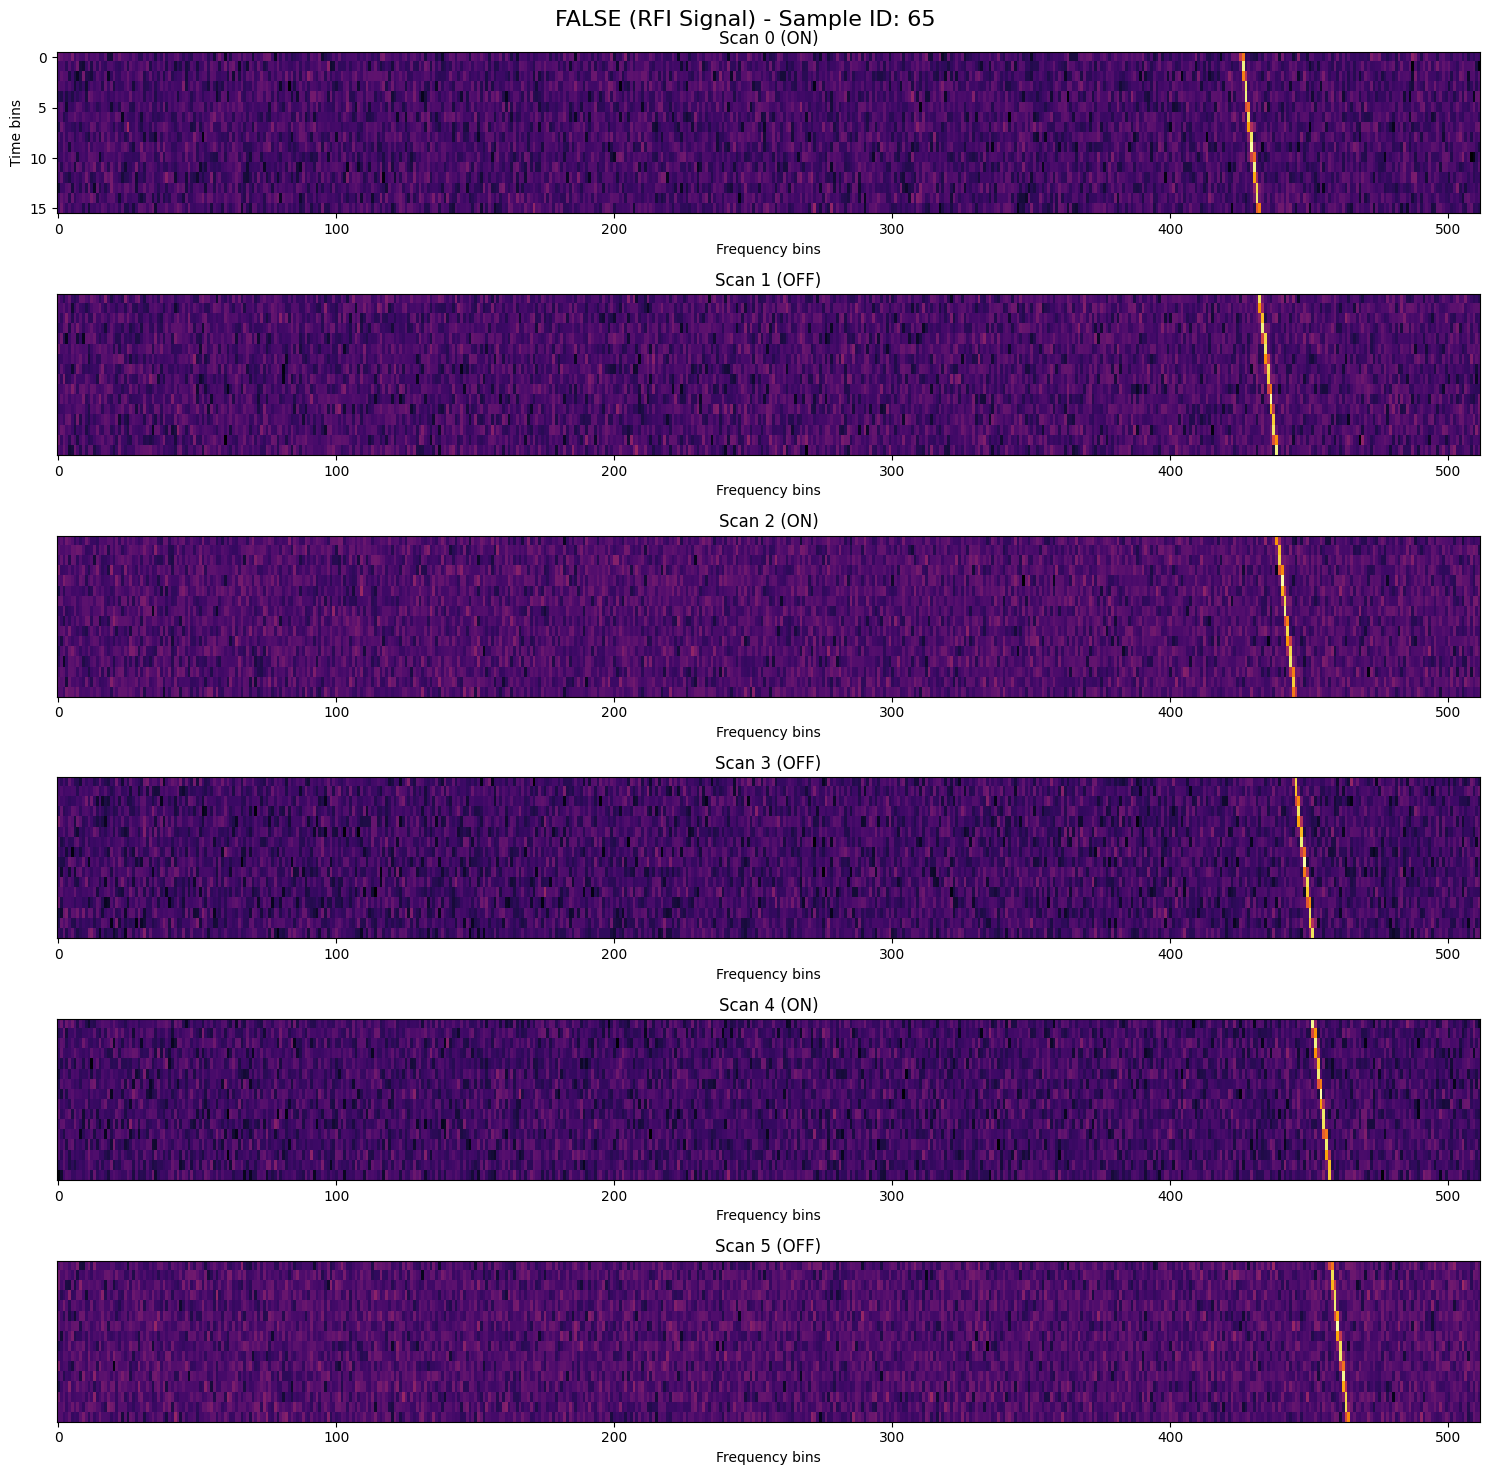

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Configurazione
FILE_PATH = "/home/filippo/TirocinioSETI/ML-SRT-SETI/src/synthetic_dataset.npz"  # O il percorso del tuo file generato
SAMPLES_TO_SHOW = 3               # Quanti esempi visualizzare per categoria

def verify_stats(data, label):
    """Controlla statistiche di base per assicurarsi che la normalizzazione sia ok"""
    print(f"\n--- VERIFICA STATISTICA: {label} ---")
    print(f"Shape: {data.shape}")
    print(f"Min Value (atteso ~0): {data.min():.4f}")
    print(f"Max Value (atteso ~1): {data.max():.4f}")
    print(f"Mean Value: {data.mean():.4f}")
    
    # Check per NaN (Not a Number)
    if np.isnan(data).any():
        print("ATTENZIONE: Ci sono NaN nei dati!")
    else:
        print("Nessun NaN rilevato.")

def plot_cadence(cadence, title, index):
    """
    Visualizza una cadenza completa (6 pannelli: ON-OFF-ON-OFF-ON-OFF)
    Input cadence shape: (6, 16, 512, 1)
    """
    fig, axes = plt.subplots(6, 1, figsize=(15, 15))
    fig.suptitle(f"{title} - Sample ID: {index}", fontsize=16)
    
    scan_labels = ["ON", "OFF", "ON", "OFF", "ON", "OFF"]
    
    for i in range(6):
        # Rimuoviamo dimensione canale (16, 512, 1) -> (16, 512)
        img = cadence[i, :, :, 0]
        
        # Visualizzazione
        ax = axes[i]
        # aspect='auto' è fondamentale perché 16x512 è molto rettangolare
        im = ax.imshow(img, aspect='auto', cmap='inferno', interpolation='nearest')
        ax.set_title(f"Scan {i} ({scan_labels[i]})")
        ax.set_xlabel("Frequency bins")
        if i == 0:
            ax.set_ylabel("Time bins")
        else:
            ax.set_yticks([])
            
    plt.tight_layout()
    plt.show()

def main():
    print(f"Caricamento {FILE_PATH}...")
    try:
        with np.load(FILE_PATH) as data:
            true_cadences = data['true_cadence']
            false_cadences = data['false_cadence']
            mixed_cadences = data['mixed_cadence']
    except FileNotFoundError:
        print("Errore: File non trovato. Assicurati di aver eseguito prima generator.py")
        return

    # 1. Verifica Statistica (Range 0-1, NaN, ecc.)
    verify_stats(true_cadences, "True Cadences (ETI)")
    verify_stats(false_cadences, "False Cadences (RFI)")

    # 2. Visualizzazione True Cadences (Segnali ETI)
    print("\nGenerazione grafici per TRUE CADENCES (Dovresti vedere segnali solo su ON)...")
    indices = random.sample(range(len(true_cadences)), SAMPLES_TO_SHOW)
    for idx in indices:
        plot_cadence(true_cadences[idx], "TRUE (ETI Signal)", idx)

    # 3. Visualizzazione False Cadences (RFI)
    print("\nGenerazione grafici per FALSE CADENCES (Dovresti vedere segnali continui/verticali)...")
    indices = random.sample(range(len(false_cadences)), SAMPLES_TO_SHOW)
    for idx in indices:
        plot_cadence(false_cadences[idx], "FALSE (RFI Signal)", idx)

if __name__ == "__main__":
    main()

In [4]:
# ==========================================
# Verifica Generazione Dati SETI
# ==========================================
# Questo script serve per verificare visivamente che:
# 1. I dati sintetici vengano generati correttamente (Drift, SNR)
# 2. La logica ON-OFF sia rispettata (il segnale deve sparire negli scan dispari)
# 3. Il preprocessing (resize e normalizzazione) non distrugga l'informazione

import matplotlib.pyplot as plt
import numpy as np
from src.generator import SetiHybridGenerator
import sys

# Configurazione visualizzazione
plt.style.use('dark_background')

def plot_cadence(cadence_data, title="Cadence"):
    """
    Visualizza le 6 osservazioni di una cadenza.
    Input shape: (6, 16, 512, 1)
    """
    # Rimuoviamo l'ultima dimensione (canale) se presente
    if cadence_data.shape[-1] == 1:
        cadence_data = cadence_data[:, :, :, 0]

    fig, axes = plt.subplots(1, 6, figsize=(24, 4))
    fig.suptitle(title, fontsize=16, color='white')
    
    labels = ['ON (0)', 'OFF (1)', 'ON (2)', 'OFF (3)', 'ON (4)', 'OFF (5)']
    
    for i in range(6):
        img = cadence_data[i]
        
        ax = axes[i]
        # Aspect='auto' adatta i pixel alla finestra, interpolation='nearest' mostra i pixel reali
        cax = ax.imshow(img, aspect='auto', cmap='viridis', interpolation='nearest')
        
        ax.set_title(f"{labels[i]}", fontsize=12)
        ax.set_xlabel("Frequency Bin (512)", fontsize=10)
        if i == 0:
            ax.set_ylabel("Time Bin (16)", fontsize=10)
        else:
            ax.set_yticks([])
    
    plt.tight_layout()
    plt.show()

def main():
    print(">>> Inizializzazione SetiHybridGenerator (Modalità Sintetica)...")
    try:
        # Batch size piccolo per visualizzazione
        BATCH_SIZE = 4
        generator = SetiHybridGenerator(background_plates=None, batch_size=BATCH_SIZE)

        # Estraiamo il primo batch
        print(">>> Generazione Batch...")
        # Il generatore restituisce: ([mixed, true, false], mixed)
        (inputs, targets) = generator[0]

        mixed_batch = inputs[0]
        true_batch = inputs[1]
        false_batch = inputs[2]

        print(f"   [OK] Shape Mixed Batch: {mixed_batch.shape}")
        print(f"   [OK] Shape True Batch:  {true_batch.shape}")
        print(f"   [OK] Shape False Batch: {false_batch.shape}")

        # ==========================================
        # Visualizzazione Pattern ON-OFF (True Data)
        # ==========================================
        print("\n>>> Visualizzazione True Positive (ETI)...")
        print("    Dovresti vedere una linea obliqua negli scan 0, 2, 4.")
        plot_cadence(true_batch[0], title="ESEMPIO: Segnale ETI (True Positive) - Drift Lineare")

        # ==========================================
        # Visualizzazione RFI/Rumore (False Data)
        # ==========================================
        print("\n>>> Visualizzazione False Positive (RFI/Noise)...")
        print("    Dovresti vedere solo rumore o linee verticali (RFI) che non rispettano il pattern ON/OFF.")
        plot_cadence(false_batch[0], title="ESEMPIO: Rumore/RFI (False Positive)")
        
    except Exception as e:
        print(f"\n[ERRORE] Si è verificato un problema durante il test:\n{e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

/home/filippo/miniconda3/envs/ml_gbt_seti/lib/python3.9/site-packages/blimpy/__init__.py:21: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


ModuleNotFoundError: No module named 'preprocessingv2'